In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = pd.read_csv('Data.csv')
X = data.drop(['Health_State_of_Meter'], axis=1)
X.head()

,Profile_Factor,Symmetry,Crossflow,Flow_Velocity1,Flow_Velocity2,Flow_Velocity3,Flow_Velocity4,Speed_of_Sound1,Speed_of_Sound2,Speed_of_Sound3,...,Gain7,Gain8,Transit_Time1,Transit_Time2,Transit_Time3,Transit_Time4,Transit_Time5,Transit_Time6,Transit_Time7,Transit_Time8
0,1.10,1.00,0.99,2.35,2.60,2.58,2.35,1485.81,1485.93,1485.94,...,-0.70,-0.70,124.15,123.91,151.62,151.28,151.56,151.22,124.25,124.02
1,1.09,1.00,1.00,3.40,3.71,3.71,3.41,1486.16,1486.30,1486.30,...,-0.70,-0.70,124.17,123.83,151.65,151.16,151.60,151.11,124.27,123.94
2,1.08,1.01,1.00,3.44,3.71,3.69,3.42,1486.32,1486.45,1486.46,...,-0.70,-0.70,124.16,123.82,151.64,151.15,151.58,151.10,124.26,123.92
3,1.09,1.01,0.99,3.40,3.73,3.66,3.37,1486.46,1486.58,1486.58,...,-0.70,-0.70,124.14,123.81,151.62,151.14,151.56,151.08,124.25,123.91
4,1.09,1.01,1.00,3.40,3.70,3.68,3.35,1486.60,1486.72,1486.73,...,-0.70,-0.70,124.13,123.80,151.61,151.12,151.55,151.07,124.24,123.90


In [ ]:
#PCA

from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X)

In [ ]:
#Visualizing the clusters
def plot_clusters(X, labels, title):
  fig, ax = plt.subplots()
  scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='brg', s=50)
  ax.set_title(title)
  ax.set_xlabel('PCA Feature 1')
  ax.set_ylabel('PCA Feature 2')
  legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Clusters")
  ax.add_artist(legend)
  plt.show()

**K Means Clustering**

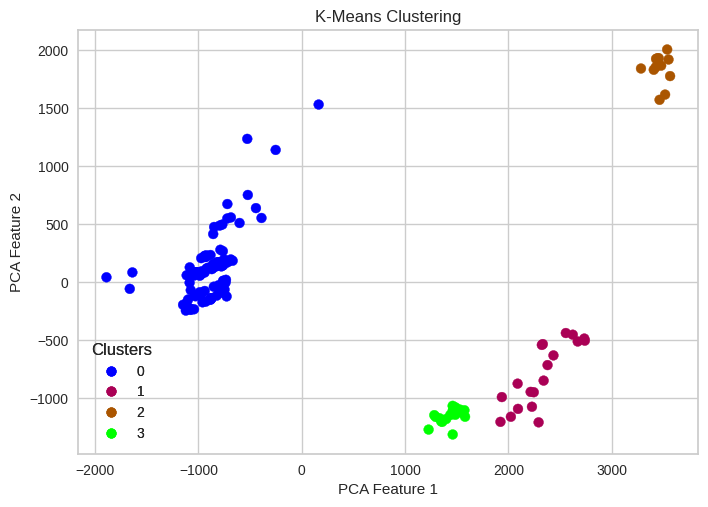

In [ ]:
from sklearn.cluster import KMeans

# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels = kmeans.labels_

plot_clusters(X_pca, labels, 'K-Means Clustering')

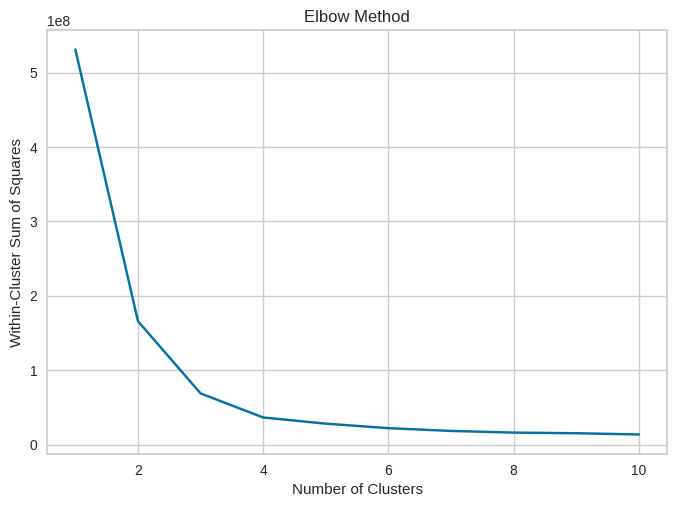

In [ ]:
# Perform elbow method to determine optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10).fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

It is not clear where the elbow joint lies, it is either for number of clusters being either 3 or 4.

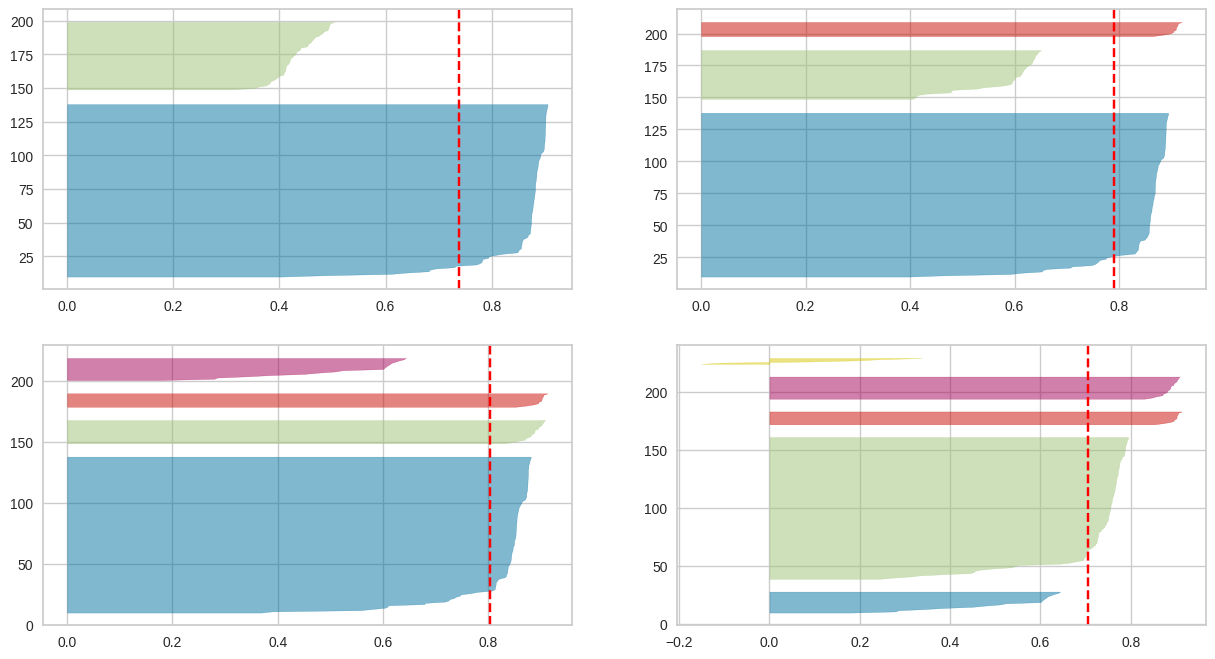

In [ ]:
#Calculating the Silhouette score to find the number of clusters

from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X) 

Here, we can see the plot where all the clusters have a Silhouette score more than the average score of the dataset (shown by the red dotted line) is with 4. Hence, number of clusters should be 4.

**Hierarchical Clustering**

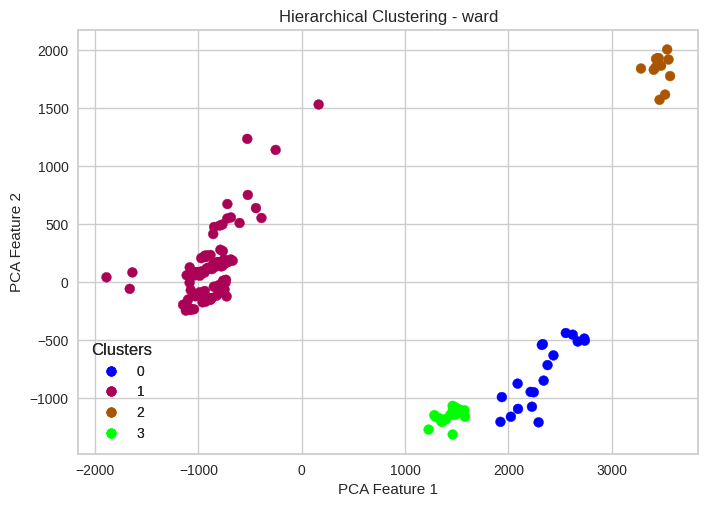

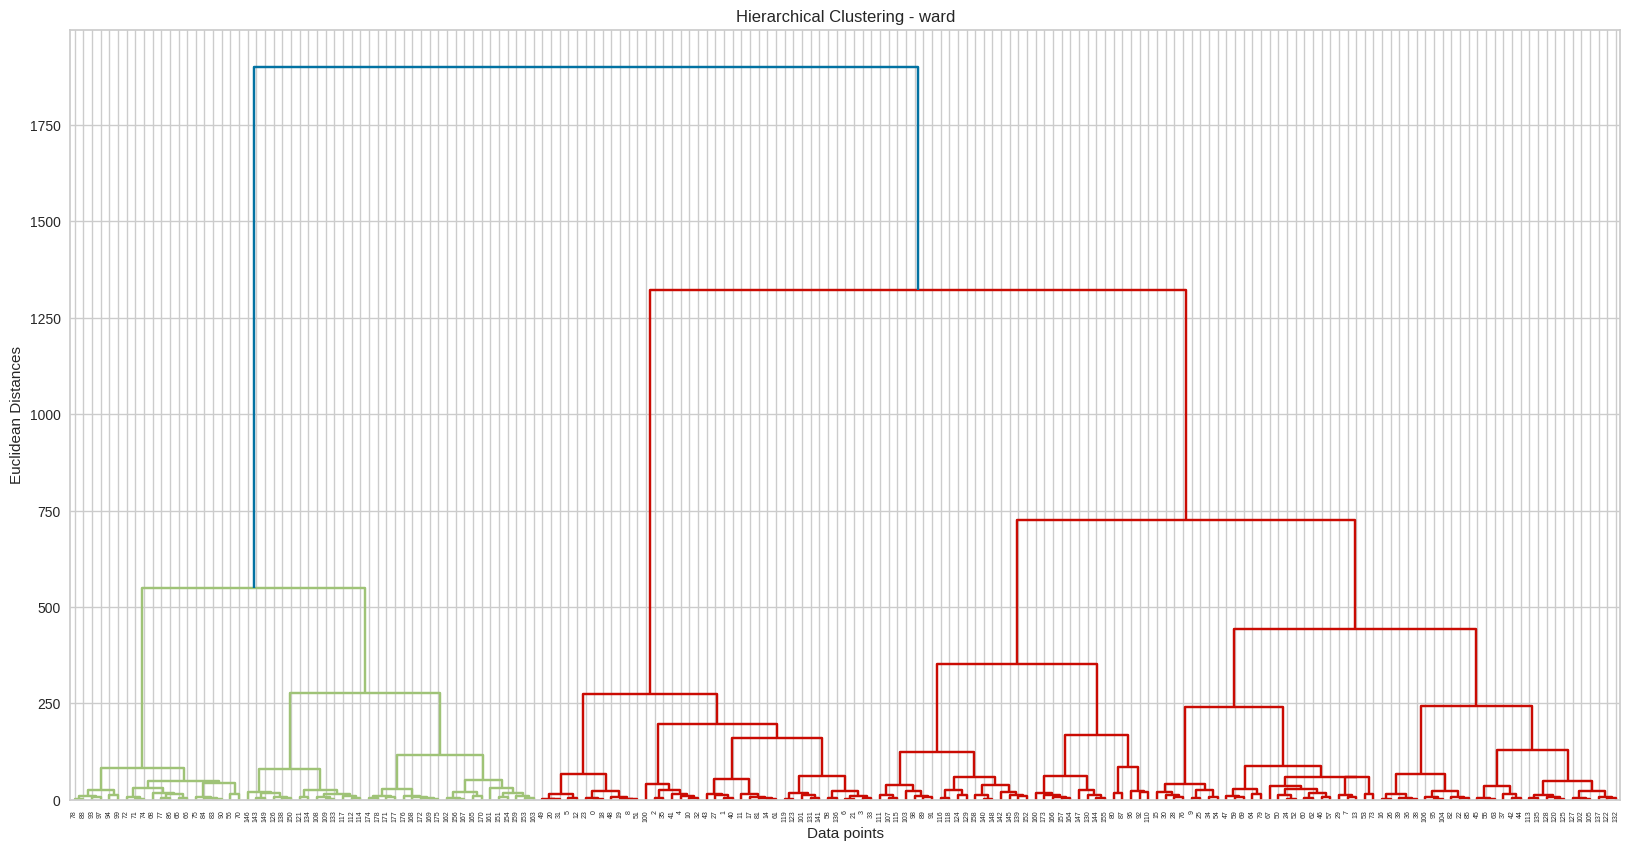

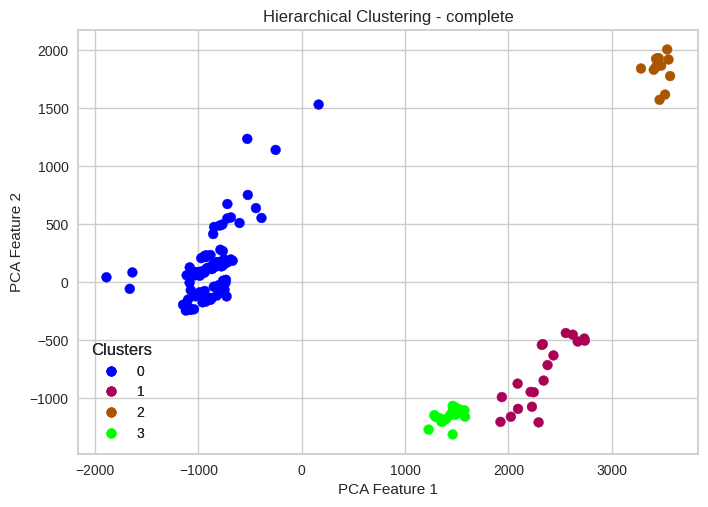

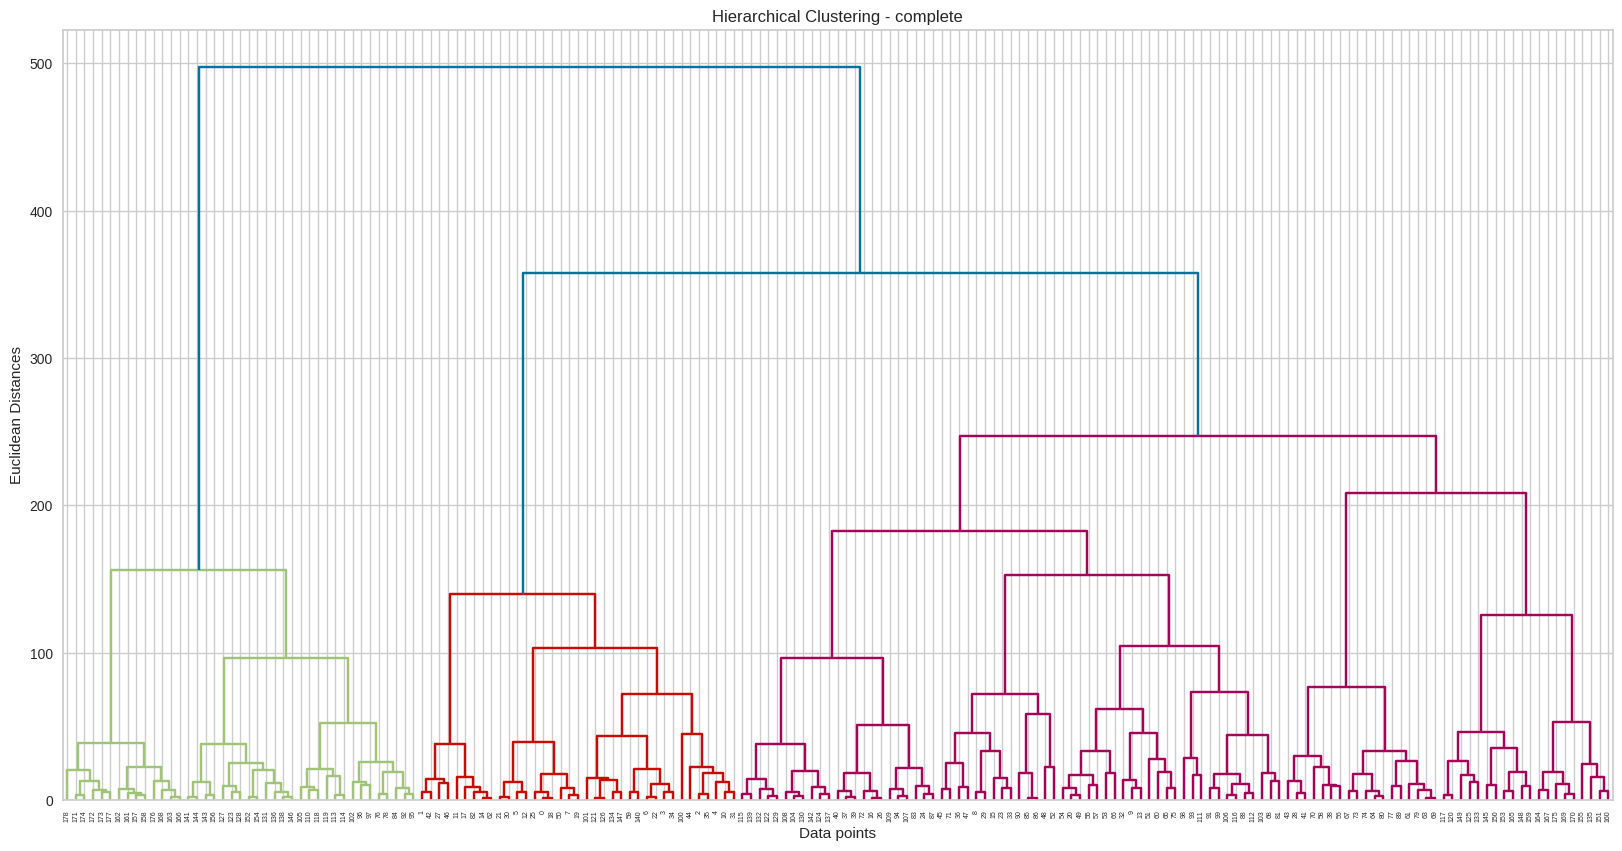

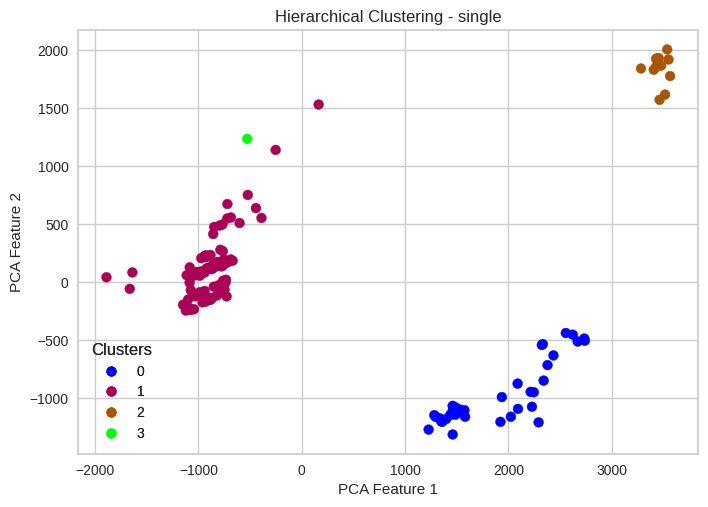

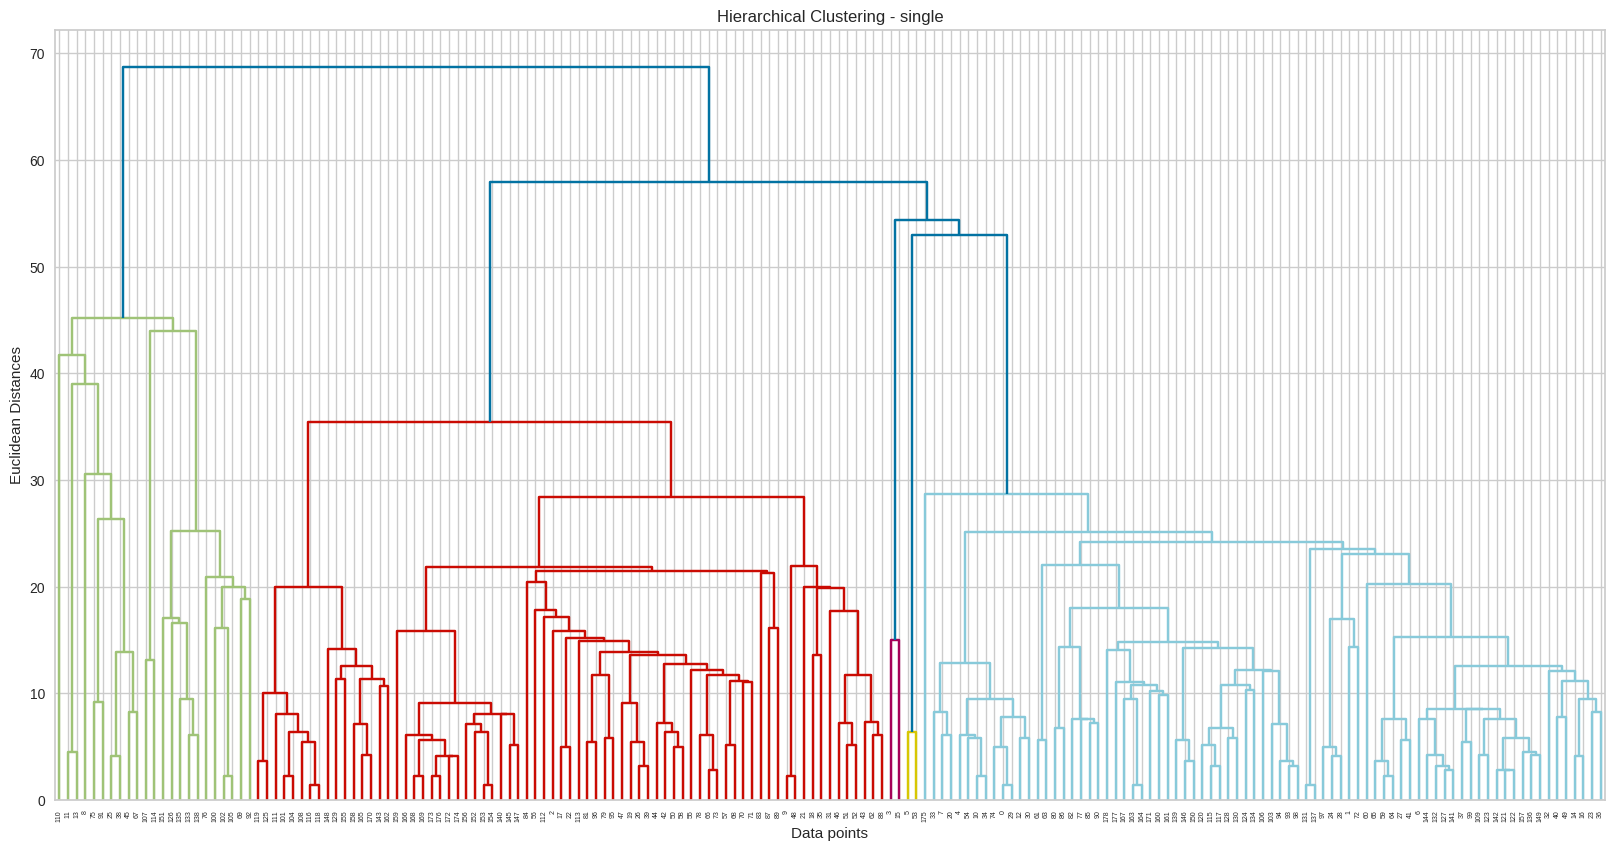

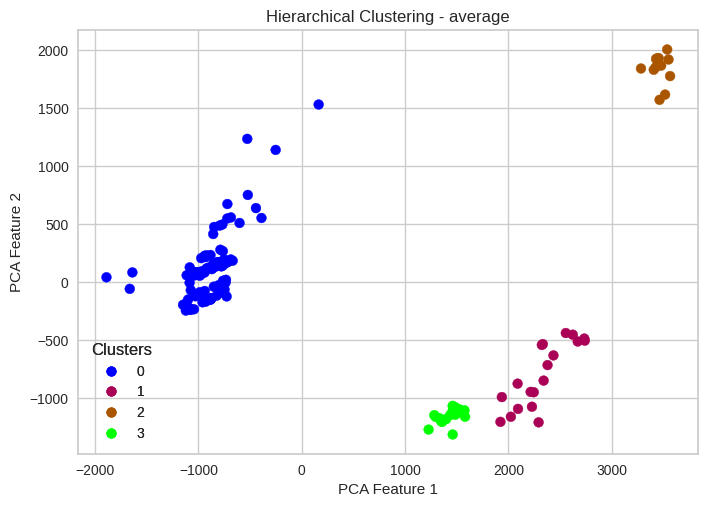

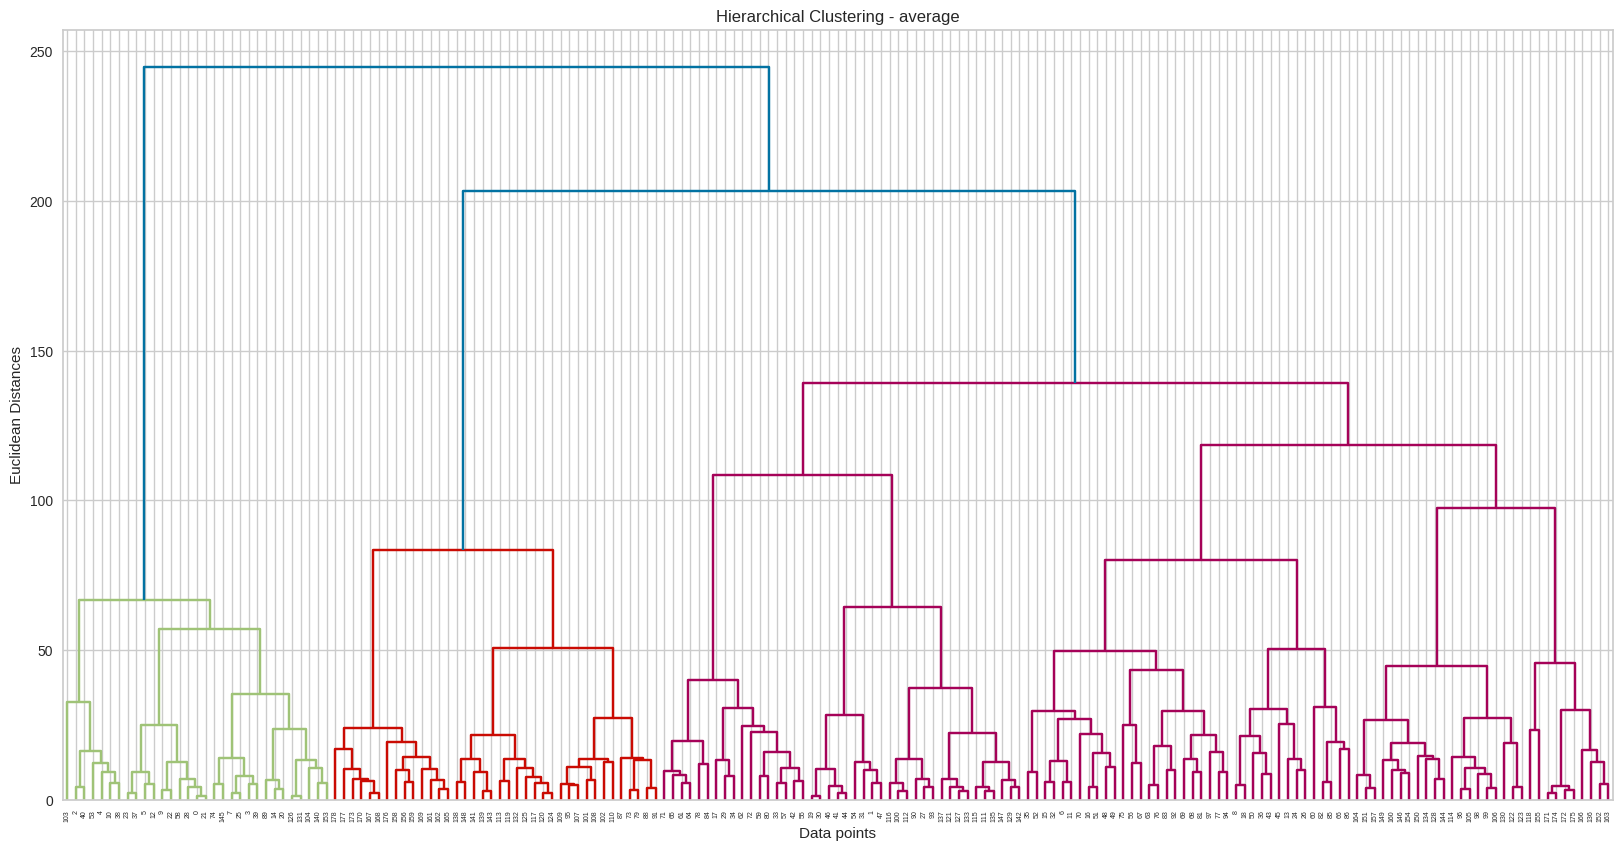

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering

# Normalize the data
X = normalize(X)

# Fit agglomerative clustering model with various linkage methods
linkages = ['ward', 'complete', 'single', 'average']
for i in linkages:
  hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage=i)
  labels = hc.fit_predict(X)
  plot_clusters(X_pca, labels, f'Hierarchical Clustering - {i}')

  # Plot Dendograms
  fig = plt.figure(figsize=(20, 10))
  dendrogram = sch.dendrogram(sch.linkage(hc.children_, method=i))
  plt.title(f'Hierarchical Clustering - {i}')
  plt.xlabel('Data points')
  plt.ylabel('Euclidean Distances')
  plt.show()


The best clusters are given by ward, complete or average clustering methods as shown in the visualizations. Euclidean distance metric is most commonly used when the predictor variables are continous and numeric. 

**Model Based**

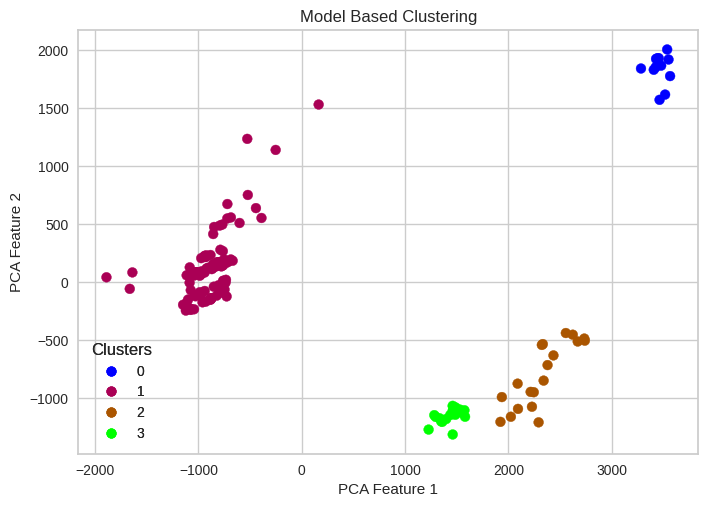

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=4, random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

# Visualize the clustering results
plot_clusters(X_pca, labels, 'Model Based Clustering')


**Variable Clustering**

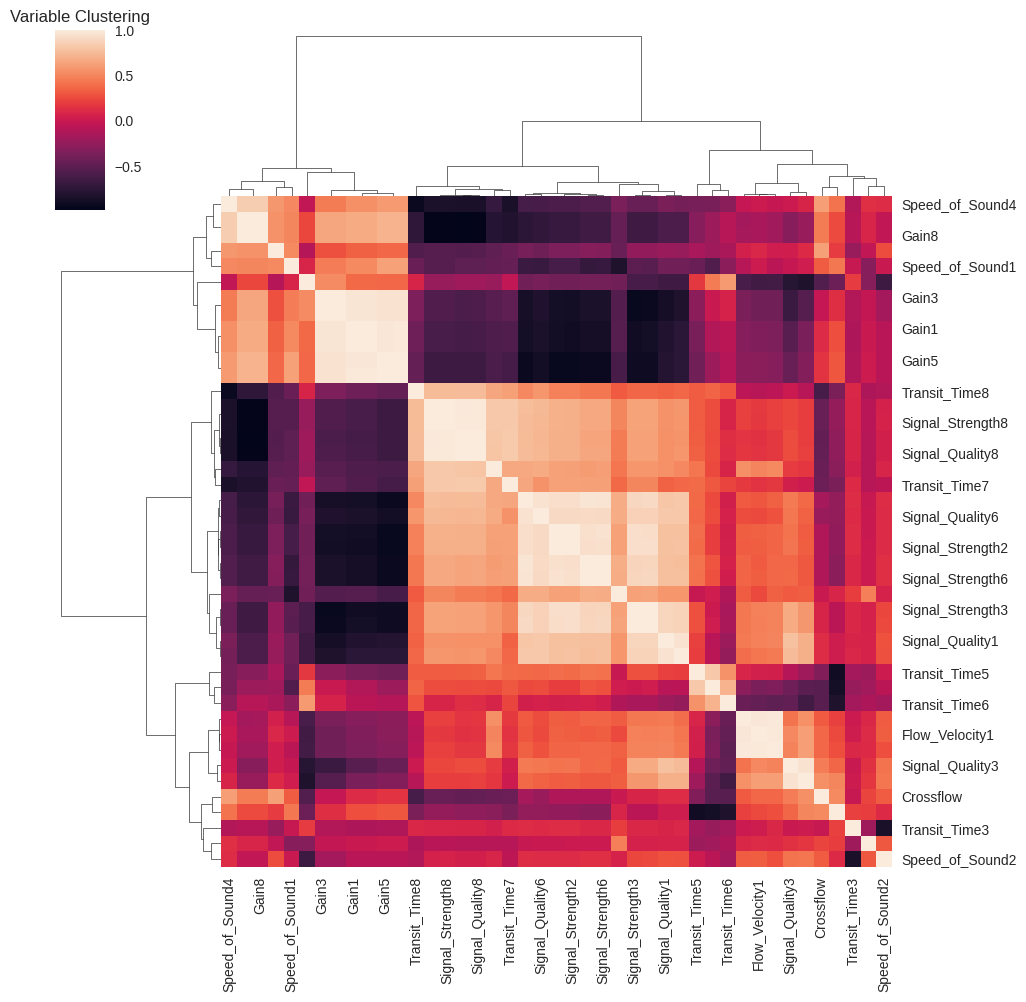

In [ ]:
import seaborn as sns
from scipy.cluster import hierarchy

# Calculate the correlation matrix
df = pd.read_excel('Meter Data.xlsx', sheet_name='D')
X = df.drop(['Health_State_of_Meter'], axis=1)
X.head()
corr = X.corr()

linkage = hierarchy.ward(corr)
sns.clustermap(corr, row_linkage=linkage, col_linkage=linkage)
plt.title("Variable Clustering")
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

# find the optimal max_distance to achieve 4 clusters
max_distances = range(1, 10)
cluster_len = {}
for max_dist in max_distances:
    clusters = fcluster(linkage, t=max_dist, criterion='distance')
    print(f"Max dist: {max_dist}, Unique cluster classes: {list(np.unique(clusters))}")
    cluster_len[max_dist] = len(list(np.unique(clusters)))
    # print("Variable Clusters: :\n", pd.DataFrame({'Variable': X.columns, 'Cluster': clusters}))

Max dist: 1, Unique cluster classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Max dist: 2, Unique cluster classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Max dist: 3, Unique cluster classes: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Max dist: 4, Unique cluster classes: [1, 2, 3, 4, 5, 6, 7]
Max dist: 5, Unique cluster classes: [1, 2, 3, 4, 5]
Max dist: 6, Unique cluster classes: [1, 2, 3, 4]
Max dist: 7, Unique cluster classes: [1, 2, 3, 4]
Max dist: 8, Unique cluster classes: [1, 2, 3]
Max dist: 9, Unique cluster classes: [1, 2, 3]


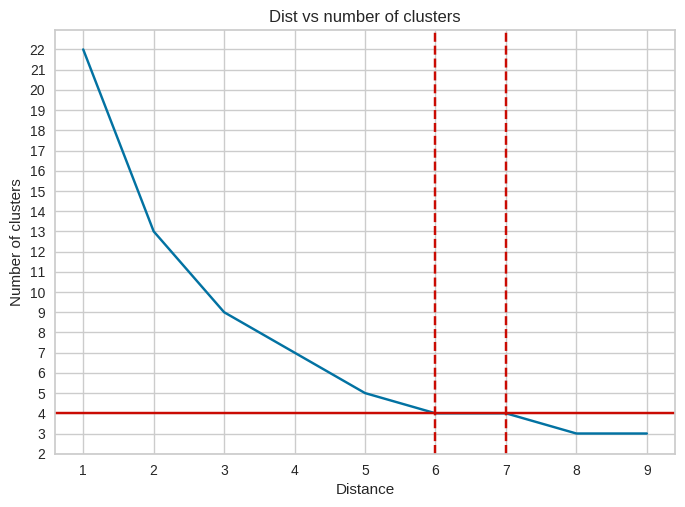

In [ ]:
plt.plot(cluster_len.keys(), cluster_len.values())
plt.title("Dist vs number of clusters")
plt.xlabel('Distance')
plt.yticks(np.arange(min(cluster_len.values()) -1, max(cluster_len.values()) + 1, step=1))
# specifying horizontal line type
plt.axhline(y = 4, color = 'r', linestyle = '-')
plt.axvline(x = 6, color = 'r', linestyle = '--')
plt.axvline(x = 7, color = 'r', linestyle = '--')
plt.ylabel('Number of clusters')
plt.show()
plt.show()

The max distance 6 or 7 gives us the required number of clusters as shown.

In [ ]:
# create the cluster labels for each variable
max_d = 6
clusters = fcluster(linkage, t=max_d, criterion='distance')
print(f"Unique cluster classes: {list(np.unique(clusters))}")
print("Variable Clusters: :\n", pd.DataFrame({'Variable': X.columns, 'Cluster': clusters}))


Unique cluster classes: [1, 2, 3, 4]
Variable Clusters: :
             Variable  Cluster
0     Profile_Factor        1
1           Symmetry        4
2          Crossflow        4
3     Flow_Velocity1        4
4     Flow_Velocity2        4
5     Flow_Velocity3        4
6     Flow_Velocity4        2
7    Speed_of_Sound1        1
8    Speed_of_Sound2        4
9    Speed_of_Sound3        4
10   Speed_of_Sound4        1
11  Signal_Strength1        2
12  Signal_Strength2        2
13  Signal_Strength3        2
14  Signal_Strength4        2
15  Signal_Strength5        2
16  Signal_Strength6        2
17  Signal_Strength7        2
18  Signal_Strength8        2
19   Signal_Quality1        2
20   Signal_Quality2        2
21   Signal_Quality3        4
22   Signal_Quality4        4
23   Signal_Quality5        2
24   Signal_Quality6        2
25   Signal_Quality7        2
26   Signal_Quality8        2
27             Gain1        1
28             Gain2        1
29             Gain3        1
30         

**Variable Selection**

In [ ]:
# Import necessary libraries
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# Load the data into a pandas dataframe
df = pd.read_csv('Data.csv')

# Separate the predictor variables and the target variable
X = df.drop('Health_State_of_Meter', axis=1)
y = df['Health_State_of_Meter']

# Convert the categorical target variable to numerical values
y = y.map({'Healthy': 0, 'Gas injection': 1, 'Installation effects': 2, 'Waxing': 3})


In [ ]:
# ANOVA F-test for feature selection - variable statistics-based method
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit_transform(X, y)
X_selected = X.columns[selector.get_support()].tolist()
# Print the selected variables
print(f'Selected features using ANOVA F-test: {X_selected}')

Selected features using ANOVA F-test: ['Flow_Velocity4', 'Speed_of_Sound4', 'Signal_Strength7', 'Signal_Strength8', 'Signal_Quality5', 'Signal_Quality7', 'Signal_Quality8', 'Gain7', 'Gain8', 'Transit_Time7']


In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# find the accuracy of the selected features

x_tr, x_ts, y_tr, y_ts = train_test_split(X[X_selected], y, test_size=0.1, random_state=0)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_tr, x_ts, y_tr, y_ts)

print(models[["Accuracy", "F1 Score", "Time Taken"]][:10])

100%|██████████| 29/29 [00:01<00:00, 25.08it/s]

                        Accuracy  F1 Score  Time Taken
Model                                                 
AdaBoostClassifier          0.89      0.89        0.11
RandomForestClassifier      0.89      0.89        0.20
LGBMClassifier              0.89      0.89        0.09
LinearSVC                   0.83      0.83        0.03
XGBClassifier               0.83      0.83        0.09
ExtraTreeClassifier         0.83      0.83        0.01
ExtraTreesClassifier        0.83      0.83        0.15
SGDClassifier               0.89      0.89        0.02
LabelPropagation            0.83      0.80        0.02
LabelSpreading              0.83      0.80        0.02


In [ ]:
# Random Forest Classifier for feature selection - model based
model = RandomForestClassifier()
model.fit(X, y)
importance = model.feature_importances_
indices = importance.argsort()[-k:][::-1]
selected_features = X.columns[indices]
X_selected = selected_features.tolist()

# Print the selected variables
print(f'Selected features using Random Forest Classifier: {X_selected}')

Selected features using Random Forest Classifier: ['Transit_Time8', 'Signal_Quality1', 'Transit_Time7', 'Signal_Strength8', 'Gain8', 'Speed_of_Sound4', 'Gain3', 'Gain7', 'Signal_Strength7', 'Gain2']


In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# find the accuracy of the selected features

x_tr, x_ts, y_tr, y_ts = train_test_split(X[X_selected], y, test_size=0.1, random_state=0)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_tr, x_ts, y_tr, y_ts)

print(models[["Accuracy", "F1 Score", "Time Taken"]][:10])

100%|██████████| 29/29 [00:01<00:00, 21.94it/s]

                        Accuracy  F1 Score  Time Taken
Model                                                 
LGBMClassifier              0.94      0.94        0.27
ExtraTreesClassifier        0.94      0.94        0.16
BaggingClassifier           0.94      0.94        0.05
LabelSpreading              0.94      0.94        0.02
LabelPropagation            0.94      0.94        0.02
RandomForestClassifier      0.94      0.94        0.18
XGBClassifier               0.94      0.94        0.09
ExtraTreeClassifier         0.89      0.89        0.01
KNeighborsClassifier        0.89      0.89        0.01
DecisionTreeClassifier      0.89      0.89        0.01


We can conclude that the variables selected by the model based are giving better accuracies as compared to variable statistics-based method.